In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from timeit import default_timer as timer
import peakutils


/Users/samcohen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.



## Generate sine wave data points

In [2]:
#Define characteristics of the data to generate
num_cycles = 20
sample_rate = 0.4
points_per_cycle = int((2*np.pi) / sample_rate)*10


x_range = np.arange(start=-np.pi/2, stop=60*2*np.pi, step=sample_rate)
print(max(x_range))
mult_start = 0.9
mult_end = 0.7
mult_range = mult_end - mult_start

period_multiplier = np.arange(mult_start, mult_end, mult_range/len(x_range))
#b = np.arange(0.5, 1, 1/len(a))
data = [np.sin(i*j) for i,j in zip(x_range, period_multiplier)]
#Shift the dataset up so we can use -1 as our NaN value
shiftData = [data[i] + -min(data) for i in range(len(data))] 
data = shiftData

print("Total data points: " + str(len(data)))


376.82920367320503
Total data points: 947


## Grab the start and end points of each cycle

In [3]:
#Negate force values to find a trough using the same peak function
negated_vals = [-i for i in data]

#Grab the peak and trough times (these are also indices)
peak_times = peakutils.indexes(data, thres=0.5, min_dist=0.1)
trough_times = peakutils.indexes(negated_vals, thres=0.5, min_dist=0.1)

#Find the time's corresponding y value
peak_vals = [data[i] for i in peak_times]
trough_vals = [data[i] for i in trough_times]

## Generate a dataset using padding

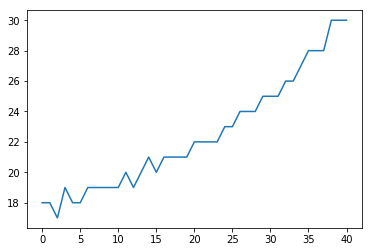

In [16]:
#Collect all the period values from the dataset
periods = []
for i in range(len(trough_times) - 1):
    period = trough_times[i+1] - trough_times[i]
    periods.append(period)
plt.plot(periods)
plt.show()

In [5]:


#Always capture three full waves. A single wave is represented by peak-to-peak. So each example needs a 3 peaks pairs.

#To capture cycles without starting and ending at only peaks each time, 
# use percentages of points realtive to the distance(num points) between the two peaks.
# so if an example starts n points before the first peak, then use n/(n_cyle_points) as the num points to use ahead



"""
Algorithm

3 periods is given by: counting points up until first peak (P), then going until 3 peaks have passed
and adding P more points to the end. 


1. Init containers for examples (holding Xs and Ys). Init pointer to step along ~1 point at a time


2. In Loop
    a. Aggregate and count how many points passed before first peak seen. Set this value as int "passed".
    b. Continue collecting points until 3 peaks seen. Then proceed for another "passed" points. Done.    


3.Last stage should just pad each example so they're all of the same dimension
    
    
    Use percentage offset of points from a peak to approximate where to end. 
        (for example that doesnt perfectly capture all peaks)




***Maybe idea is that it should always have at least enough peaks to form n-1 waves and 
extrapolate the rest based on previously seen info

Maybe should always see n peaks, and expand if not

"""





'\nAlgorithm\n\n3 periods is given by: counting points up until first peak (P), then going until 3 peaks have passed\nand adding P more points to the end. \n\n\n1. Init containers for examples (holding Xs and Ys). Init pointer to step along ~1 point at a time\n\n\n2. In Loop\n    a. Aggregate and count how many points passed before first peak seen. Set this value as int "passed".\n    b. Continue collecting points until 3 peaks seen. Then proceed for another "passed" points. Done.    \n\n\n3.Last stage should just pad each example so they\'re all of the same dimension\n    \n    \n    Use percentage offset of points from a peak to approximate where to end. \n        (for example that doesnt perfectly capture all peaks)\n\n\n\n\n***Maybe idea is that it should always have at least enough peaks to form n-1 waves and \nextrapolate the rest based on previously seen info\n\nMaybe should always see n peaks, and expand if not\n\n'

18
30
num points: 947
num examples:836
train end: 1.9999227231638976
len data: 947
len samples[-1]: 99
len labels[-1]: 33
test_input_points: 1.9732621378291717
835
[1.9732621378291717, 1.9000393085412908, 1.7838602858671435, 1.6303673048304423, 1.4469589848899873, 1.2424288571718671, 1.0265400902231874, 0.8095571376819882, 0.6017568676710815, 0.4129424805711023, 0.25198315792756076, 0.12640094222597398, 0.04202390723281091, 0.0027213694524625964, 0.010232879928835148, 0.06409821962531725, 0.16169081924930073, 0.29835216417756605, 0.46762005499099757, 0.6615392906768671, 0.8710396202495829, 1.086362834859044, 1.2975187747255046, 1.4947488892425704, 1.6689758543077717, 1.812218611411327, 1.9179539954416456, 1.9814087670871259, 1.9997692280824264, 1.972299509485682, 1.900363897979192, 1.7873530022840773, 1.6385179561213374, 1.460721005670344, 1.2621145521339099, 1.0517638500618713, 0.8392309651313775, 0.6341391717386464, 0.4457376605799819, 0.28248620996088936, 0.1516783737018732, 0.05911

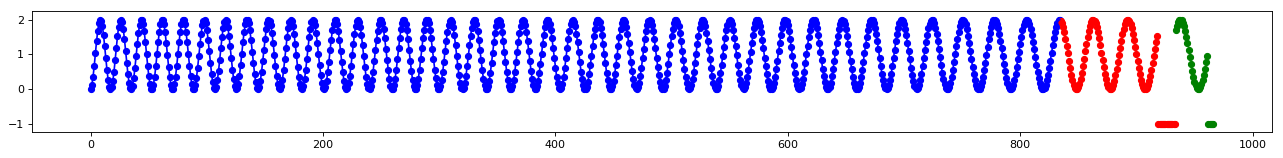

In [25]:
def generate_dataset_const(data, default_period, peak_indices, x_cycles=3, y_cycles=1):
    #Just use a window size that corresponds to the average of the the period of the wave that the first point
    # lies in and the period of the wave that the last point lies in. 
    # The predict window size should be period that last feed-in point lies in + (plus)
    # the growth we saw between the last two waves
    """For now: Decide num points to use by finding num points in first and last wave and slide size over this domain.
    Then each point along the series should correspond to a "period" value. 
    Each time we slide one point over, we then look at how much we should expand on the right side (later in series).
    This amount of expansion is determined by the average period value of all the points in the past window.
    """
    
    
    #Set some variables to use
    smallest_period = peak_indices[1] - peak_indices[0]
    largest_period = peak_indices[-1] - peak_indices[-2]
    print(smallest_period)
    print(largest_period)
    period_range = largest_period - smallest_period
    holder_size = int(largest_period * 1.1)
    
    #Assign an approximate period-value to each point over the distribution from smallest to largest
    approx_periods = [int(smallest_period + i) for i in np.linspace(0, period_range, len(data))]
    
    
    n_prev = smallest_period*3
    n_forecast = smallest_period
    fig=plt.figure(figsize=(20, 1), dpi= 80, facecolor='w', edgecolor='k')
    
    xs = list()
    ys = list()
    
    #Loop over the data and convert into samples
    for i in range(len(data)):
        
        #Exit if we dont have enough points remaining to construct another example
        if((i+n_prev) > len(data) or (i+n_prev+n_forecast) > len(data)):
            break
        
        #Init our examples input and label
        x = [-1]* (holder_size*x_cycles)
        y = [-1]* (holder_size*y_cycles)
        #print("X is of size: " + str(len(x)))
        
        x[:n_prev] = data[i:i+n_prev]
        y[:n_forecast] = data[i+n_prev:i+n_prev+n_forecast]
        
        xs.append(x)
        ys.append(y)

        
        #print("X size: "+str(len(data[i:i+n_prev])) + " & total size: "+str(len(x)))
        #print(x)
        #print()
        #print("Y size: "+str(len(data[i+n_prev:i+n_prev+n_forecast])) + " & total size: "+str(len(y)))
        #print(y)
        #print()
        #print("-----------------------------------------")
        
        
        
        #Calculate the new period to use
        new_period_size = int(np.average(approx_periods[i:i+n_prev]))
        n_prev = new_period_size*3
        n_forecast = new_period_size
        #print("new period size: " + str(new_period_size))
        

    print("num points: " +str(len(data)))
    print("num examples:" + str(len(xs)))
    #return xs, ys

    
    #samples, labels = generate_dataset_const(new_exper_data, peak_times)
    samples = xs
    labels = ys


    #Set the figure parameters
    fig=plt.figure(figsize=(20, 2), dpi= 80, facecolor='w', edgecolor='k')

    #Grab the points for each section of the plot
    #train_points, test_input_points, test_label_points = data[:-(len(samples[-1])+len(labels[-1]))], samples[-1], labels[-1]
    len_final_example = n_prev + n_forecast
    
    train_points, test_input_points, test_label_points = data[:-len_final_example], samples[-1], labels[-1]

    print("train end: " + str(train_points[-1]))
    print("len data: " + str(len(data)))
    print("len samples[-1]: " + str(len(samples[-1])))
    print("len labels[-1]: " + str(len(labels[-1])))
    print("test_input_points: " +str(test_input_points[0]))
    print(len(train_points))
    
    print(samples[-1])

    #Plot the training data and the underlying curve in blue 
    plt.plot(train_points, color="blue")
    train_plot_x = [x for x in range(len(train_points))]
    plt.scatter(train_plot_x, train_points, color="blue", s=30)

    #Plot the test example X in red
    test_input_xs = [x +len(train_points) for x in range(len(test_input_points))]
    plt.scatter(test_input_xs, test_input_points, color="red", s=30)

    #Plot the test target label in green
    test_label_xs = [x +(len(train_points)+len(test_input_points)) for x in range(len(test_label_points))]
    plt.scatter(test_label_xs, test_label_points, color="green", s=30)

    train_examples = xs[:-1]
    train_labels = ys[:-1]
    test_example = xs[-1]
    test_label = ys[-1]
    
    return train_examples,train_labels, test_example, test_label
    
#new_exper_data = [i for i in range(len(data))]

train_examples,train_labels, test_example, test_label = generate_dataset_const(data, peak_times)

print(len(train_examples))
print(len(train_labels))
print(len(test_example))
print(len(test_label))

    
    
    

## Example generation with pandas dataframe 

In [164]:
def generate_dataset(data, default_period, peak_indices, x_cycles=3, y_cycles=1):
    """
    - Each X and label is "set" in size (will contain variable num of useless datapoints at end)
    - So we combine these adjacent to one another and stack all examples vertically 
    TODO: We should make the length grow from the inside out; the prev points should extend backwards?***
    #TODO: Maybe dont split the train inside here, maybe just output a train and test var
    """
    #Set some variables to use
    smallest_period = peak_indices[1] - peak_indices[0]
    largest_period = peak_indices[-1] - peak_indices[-2]
    print("Smallest Period: " + str(smallest_period))
    print("Largest Period: " + str(largest_period))
    period_range = largest_period - smallest_period
    #holder_size = int(largest_period * 1.1)
    holder_size = default_period
    #Assign an approximate period-value to each point over the distribution from smallest to largest
    approx_periods = [int(smallest_period + i) for i in np.linspace(0, period_range, len(data))]
    
    #Set the variable number of points to use on first iteration
    n_prev = smallest_period * x_cycles
    n_forecast = smallest_period * y_cycles
    
    
    #Init the pandas dataframe to hold our new dataset (TODO!!! probably modularize into seperate function)
    col_names = list()

    for i in range(default_period*x_cycles, 0, -1):
        col_names += ['var(t-%d)' %  i]
    
    for i in range(0, default_period*y_cycles):
        if i == 0:
            col_names += ['var(t)']
        else:
            col_names += ['var(t+%d)' % i]

    df = pd.DataFrame(columns = col_names)
    
    print("Just after creation, the df is shape: " + str(df.shape))
    
    #Loop over the data and convert into samples
    for i in range(len(data)):
        #print("----------In Loop: i= "+str(i)+" ---------------------" )
        
        #Exit if we dont have enough points remaining to construct another example
        if((i+n_prev) > len(data) or (i+n_prev+n_forecast) > len(data)):
            print("we're breaking!")
            break
        
        #Init our examples input and label (TODO!!! combine these lines into one as x & y in same row now)
        x = [-1]* (holder_size*x_cycles)
        #print("x size: " +str(len(x)))
        y = [-1]* (holder_size*y_cycles)
        #print("y size: " +str(len(y)))

        #print("X is of size: " + str(len(x)))
        
        #Set real values in the default size holders
        #print("LOOK HERE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        #print(len(x[-n_prev:]))
        #print(len(data[i:i+n_prev]))
        x[-n_prev:] = data[i:i+n_prev] #Store at the end of the array
        y[:n_forecast] = data[i+n_prev:i+n_prev+n_forecast] #Store at the beginning of the array
        
        #Add the x & y pair as a row in the dataframe
        df.loc[i] = x + y 

#         print("x:")
#         print(x)
#         print("length x: "+str(len(x)))
#         print("n_prev (x): " + str(n_prev))
#         print()
#         print("y: ")
#         print(y)
#         print("length y: "+str(len(y)))
#         print("n_forecast (y): " +str(n_forecast))

#         print()
#         print("x+y: ")
#         print(x+y)
#         print()
#         print()
#         print("df.iloc: ")
#         print(df.iloc[i])
        
        
        #Calculate the new period to use
        new_period_size = int(np.average(approx_periods[i:i+n_prev]))
        n_prev = new_period_size*3
        n_forecast = new_period_size
        #print("new period size: " + str(new_period_size))
        

    print("num points: " +str(len(data)))
    print("dataframe shape:" + str(df.shape))

    #Set the figure parameters
    fig=plt.figure(figsize=(20, 2), dpi= 80, facecolor='w', edgecolor='k')

    len_final_example = n_prev + n_forecast
    
    #Remeber: iloc works with weird indexing: [rows, cols]
    #First index is rows and second is columns
    train_examples = df.iloc[:-1, :holder_size*x_cycles]
    train_labels = df.iloc[:-1, holder_size*x_cycles:]
    
    test_example = df.iloc[-1, :holder_size*x_cycles]
    test_label = df.iloc[-1, holder_size*x_cycles:]
    
    return train_examples,train_labels, test_example, test_label
    

new_exper_data = [i for i in range(30)]
default_period = 5
new_exper_peak_times = [0,1,2,4,6,8,11, 13, 16, 18, 21, 25, 30 ]

train_examples,train_labels, test_example, test_label = generate_dataset(new_exper_data, default_period, new_exper_peak_times)

print("train_examples: " + str(len(train_examples)))
print("train_labels: "+ str(len(train_labels)))
print("test_example: "+ str(len(test_example)))
print("test_label: " + str(len(test_label)))
print(test_example.values)
    
    

Smallest Period: 1
Largest Period: 5
Just after creation, the df is shape: (0, 20)
we're breaking!
num points: 30
dataframe shape:(19, 20)
train_examples: 18
train_labels: 18
test_example: 15
test_label: 5
[-1 -1 -1 -1 -1 -1 18 19 20 21 22 23 24 25 26]


## Plotting the dataset

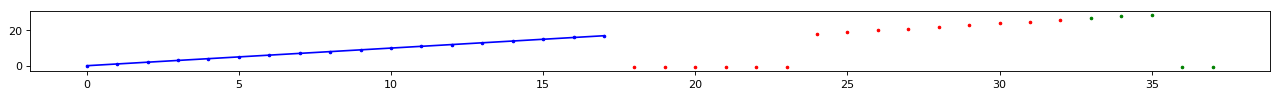

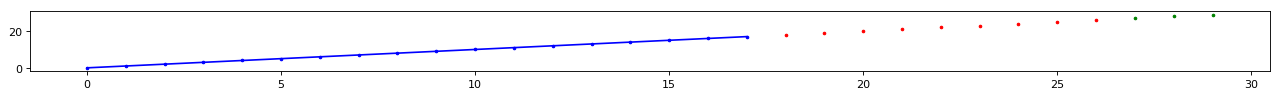

## Define LSTM architecture

* NOTE: We have to switch the input such that 2nd dimension (time_steps) is representative of how many steps to look into the past.  
* NOTE: "features" is dim 1. It is just representative of the number of dimensions in our input, nothing to do with number of points, nor the number of points on the output.

In [197]:
# fit an LSTM network to training data

def fit_lstm(X, y, n_batch, nb_epoch, n_neurons):
    """
    Function to convert data so it can be interpreted by the LSTM and then trains and returns the LSTM model
    Note: 
    
    Input to every LSTM layer must be 3 dimensional
    - Samples: one sequence is one sample. A batch is comprised of 1 or more samples.
    - Time Steps: One time step is one point of observation in the sample.
    - Features: One feature is one observation at a time step.
    
    """
    
    architecture = ""
    # reshape training into [samples, timesteps, features]
    
    #Split the training data into X (input) and y (labels)
    #X, y = train[:, 0:n_prev], train[:, n_prev:]

    print("X shape: " + str(X.shape))
    print("y shape: " + str(y.shape))
    
    #Reshape X so Samples=num_examples, TimeSteps=1, Features = n_lag
    #X = X.reshape(X.shape[0], 1, X.shape[1]) !!!!
    X = X.reshape(X.shape[0],X.shape[1],1)
    

    model = Sequential()
    #We feed in batch sizes of dimension: (n_batch, 1, n_lag)
    print("sam")
    print((n_batch, X.shape[1], X.shape[2]))
    print(X.shape)
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=False))
    architecture += "LSTM; "
    #model.add(Dense(300))
    #Last layer is a fully connected layer to output size n_forecast
    model.add(Dense(y.shape[1]))
    architecture += "Dense output; "
    #Compile the network
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    #Fit the network to the training data
    for i in range(nb_epoch):
        start = timer()
        print(i)
        
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
        
        end = timer()
        print("Epoch duration: " + str(end - start))
    return model, architecture

In [201]:
#Cut off some training data if necessary for batch sizes
# print()
# print(train.shape)
# train = train[:-26]
# print(train.shape)

## Train the Neural Network

In [205]:
n_epochs = 200
n_batch = 1
n_neurons = 30
#print("train shape: " + str(train.shape))
#train_cut = train[:-2,:]
#train_cut = train
#print("train shape: " + str(train_cut.shape))
train = train_examples.values
print("train shape: " +str(train.shape))
model, architecture = fit_lstm(train, train_labels.values, n_batch, n_epochs, n_neurons)


train shape: (18, 15)
X shape: (18, 15)
y shape: (18, 5)
sam
(1, 15, 1)
(18, 15, 1)
0
Epoch duration: 2.1798318729852326
1
Epoch duration: 0.15886518801562488
2
Epoch duration: 0.18446394801139832
3
Epoch duration: 0.16804521199082956
4
Epoch duration: 0.18662840803153813
5
Epoch duration: 0.18076500500319526
6
Epoch duration: 0.188202788005583
7
Epoch duration: 0.16728062595939264
8
Epoch duration: 0.18828360800398514
9
Epoch duration: 0.1737979970057495
10
Epoch duration: 0.19013439200352877
11
Epoch duration: 0.1658249210449867
12
Epoch duration: 0.19040247198427096
13
Epoch duration: 0.16757730999961495
14
Epoch duration: 0.18836440599989146
15
Epoch duration: 0.16492578200995922
16
Epoch duration: 0.18758039199747145
17
Epoch duration: 0.16761341999517754
18
Epoch duration: 0.20178490196121857
19
Epoch duration: 0.20262548903701827
20
Epoch duration: 0.20296065200818703
21
Epoch duration: 0.19806384801631793
22
Epoch duration: 0.18006195599446073
23
Epoch duration: 0.2166083870106

In [206]:
print(train.shape)

(18, 15)


# 

In [207]:
def forecast_lstm(model, X, n_batch):
    #Reshape input data to [samples, timesteps, features] for the LSTM
    
    Xs = [X for _ in range(n_batch)]
    
    x_stack = np.stack((Xs))
    print(x_stack.shape)
    
    X = x_stack.reshape(n_batch,len(X),1)
    
    #Make a forecast    
    forecast = model.predict(X, batch_size=n_batch)
    
    #Convert to array
    return [y_hat for y_hat in forecast[0,:]]

In [209]:
#Run on test data
#test_x, test_y = test[0:n_prev], test[n_prev:]
test_x, test_y = test_example.values, test_label.values
test_x = np.array(test_x)
print(len(test_x))
y_hat = forecast_lstm(model, test_x, n_batch)
print("First true label: " + str(test_y[0]))
print("First forecast: " +str(y_hat[0]))

RMSE = []
for i in range(n_forecast):
    RMSE.append(math.sqrt(mean_squared_error(test_y, y_hat)))
print("Average RMSE: ")
print(sum(RMSE)/len(RMSE))

15
(1, 15)
First true label: 27
First forecast: 25.679358
Average RMSE: 
4.978170647194297


## Plotting initial training data

3


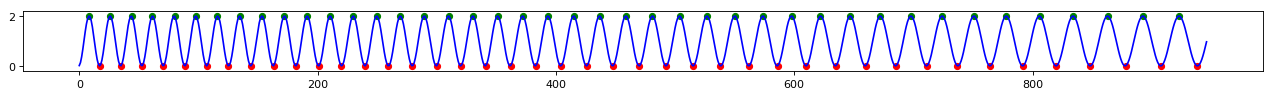

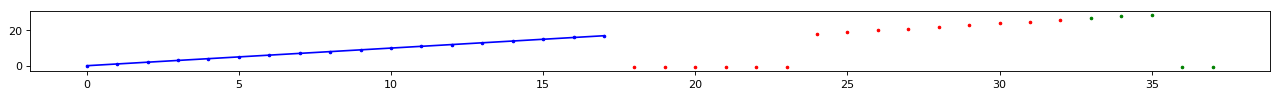

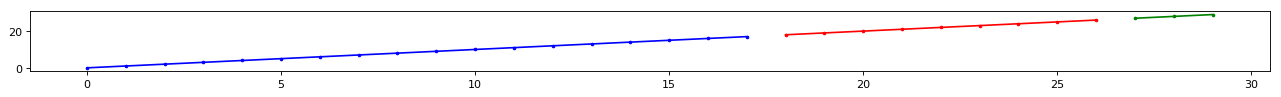

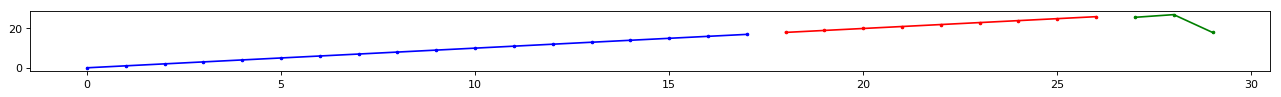

In [222]:
#Plot whole dataset
fig=plt.figure(figsize=(20, 1), dpi= 80, facecolor='w', edgecolor='k')

#Line plot along the true data
plt.plot([x for x in range(len(data))], data, color="blue")

#Plot the training points in green
plt.scatter(peak_times, peak_vals, color="green", s=30)
plt.scatter(trough_times, trough_vals, color="red", s=30)


#--------------------------------------------------------------------------------------------
#Plotting the dataframe results
fig=plt.figure(figsize=(20, 1), dpi= 80, facecolor='w', edgecolor='k')

#Grab the data without padding
test_in_raw = test_example.values 
test_in = [test_in_raw[i] for i in range(len(test_in_raw)) if test_in_raw[i] >= 0]
test_out_raw = test_label.values
test_out = [test_out_raw[i] for i in range(len(test_out_raw)) if test_out_raw[i] >= 0]
test_len = len(test_in) + len(test_out) #default_period * 4


#Plot the training data and the underlying curve in blue 
train_plot_points= new_exper_data[:-test_len]
plt.plot(train_plot_points, color="blue")
train_plot_x = [x for x in range(len(train_plot_points))]
plt.scatter(train_plot_x, train_plot_points, color="blue", s=5)

#Plot the test example X in red
test_input_plot_points = test_example.values
test_input_xs = [x +len(train_plot_points) for x in range(len(test_input_plot_points))]
plt.scatter(test_input_xs, test_input_plot_points, color="red", s=5)

#Plot the test target label in green
test_label_points = test_label.values
test_label_xs = [x +(len(train_plot_points)+len(test_input_plot_points)) for x in range(len(test_label_points))]
plt.scatter(test_label_xs, test_label_points, color="green", s=5)


#--------------------To better visualize, we can also remove the unused padding-----------------------------
padding_removed = [t[i] for i in range(len(t)) if t[i] >= 0]

#Plotting the dataframe results
fig=plt.figure(figsize=(20, 1), dpi= 80, facecolor='w', edgecolor='k')
len_final_example = default_period * 4

#Plot the training data and the underlying curve in blue 
plt.plot(train_plot_points, color="blue")
plt.scatter(train_plot_x, train_plot_points, color="blue", s=5)

#Plot the test example X in red (no padding)
test_in_xs = [x +len(train_plot_points) for x in range(len(test_in))]
plt.scatter(test_in, test_in_xs, color="red", s=5)
plt.plot(test_in, test_in_xs, color="red")

#Plot the test target label in green (no padding)
test_label_xs = [x +(len(train_plot_points)+len(test_in_xs)) for x in range(len(test_out))]
plt.scatter(test_label_xs, test_out, color="green", s=5)
plt.plot(test_label_xs, test_out, color="green")


#Plot the actual results----------------------------------------------------------------

#Plotting the dataframe results
fig=plt.figure(figsize=(20, 1), dpi= 80, facecolor='w', edgecolor='k')

#Plot the training data and the underlying curve in blue 
plt.plot(train_plot_points, color="blue")
plt.scatter(train_plot_x, train_plot_points, color="blue", s=5)

#Plot the test example X in red (no padding)
test_in_xs = [x +len(train_plot_points) for x in range(len(test_in))]
plt.scatter(test_in, test_in_xs, color="red", s=5)
plt.plot(test_in, test_in_xs, color="red")


#Plot the test target label in green (no padding)

#Remove padding from the prediction
y_hat = [y_hat[i] for i in range(len(y_hat)) if y_hat[i] >= 0]

test_label_xs = [x +(len(train_plot_points)+len(test_in_xs)) for x in range(len(y_hat))]
plt.scatter(test_label_xs, y_hat, color="green", s=5)
plt.plot(test_label_xs, y_hat, color="green")




print(len(y_hat))




## Evaluate the forecast based on its RMSE and record results

In [211]:
#Evaluate forecasts and record them in a text file
from sklearn.metrics import mean_squared_error
import math

RMSE = []
for i in range(n_forecast):
    RMSE.append(math.sqrt(mean_squared_error(test_y, y_hat)))
print("RMSE: ")
print(RMSE)

#Open the textfile to append to
text_file = open("results.txt", "a")

text_file.write("\n\nNEW TRIAL: \n\n")
text_file.write("Architecture: " + str(architecture)+"\n")
text_file.write("Epochs: " + str(n_epochs)+"\n")
text_file.write("Average RMSE: " + str(sum(RMSE)/len(RMSE))+"\n")
text_file.write("Average predicted value: " + str(sum(y_hat)/len(y_hat))+"\n")
text_file.write("Variance of predicted values: " + str(np.var(y_hat))+"\n")
text_file.write("Min: " + str(min(y_hat))+ " Max: " +str(max(y_hat)) + "\n")


#Close the file after writing results to it
text_file.close()


RMSE: 
[4.978170647194297]


## Display Results
* Blue: Sample used for prediction
* Green: What we are trying to predict
* Red: Actual prediction

y size: 5
x size: 5


NameError: name 'n_test' is not defined

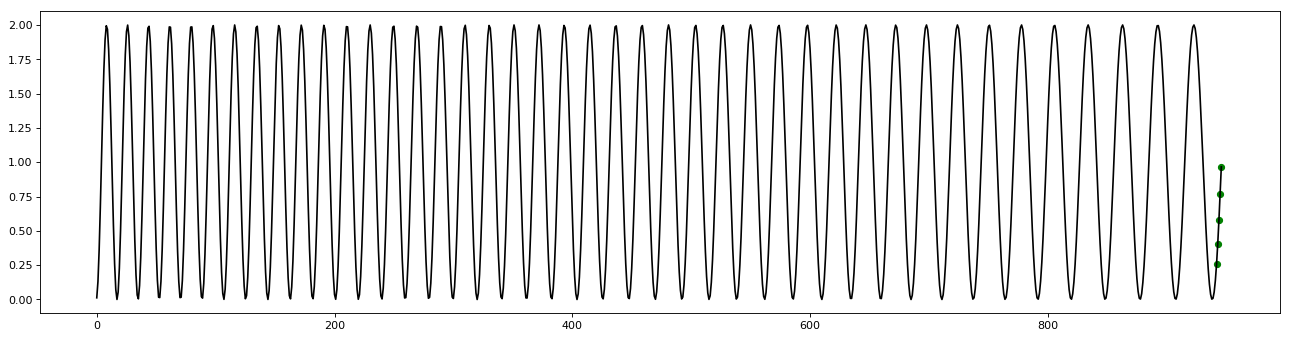

In [212]:
#Display forecasts

#Build a larger figure
fig=plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')

#data = data[:int(len(data)/2)]
plt.plot(data, color="black")



xs = [x for x in range(len(data))]
#plt.scatter(xs, data, color="blue", s = 15)






#Define indices for which to plot the prediction
index_start = len(data) - len(y_hat)
index_end = len(data)
labels_x = [x for x in range(index_start, index_end)]

#print(len(test_y))
#print(len(y_hat))
#print(len(labels_x))
#mod_data = [y+ for y in data[-40:]]
#fake_y = [y for y in range()]



#Display true labels in green
#Display true labels in green
true_labels = [data[y] for y in range(index_start, index_end)]
plt.scatter(labels_x, true_labels, color="green", s=30)

print("y size: " +str(len(y_hat)))
print("x size: " +str(len(labels_x)))


#Display the X of that this prediction was based on
test_x_start = len(data) - n_test
test_x_end = len(data) - len(y_hat)
test_x_indices = [x for x in range(test_x_start, test_x_end)]

test_x_labels = [data[y] for y in test_x_indices]

print(len(test_x_indices))
print(len(test_x_labels))

plt.scatter(test_x_indices, test_x_labels, color="blue", s=30)

#Display forecasted labels in red
index_start = test_x_end
index_end = len(data)
labels_x = [x for x in range(index_start, index_end)]
plt.scatter(labels_x, y_hat, color="red", s=30)

print("Epochs: " + str(n_epochs))
print("Average RMSE: " + str(sum(RMSE)/len(RMSE)))
print("Average predicted value: " + str(sum(y_hat)/len(y_hat)))
print("Variance of predicted values: " + str(np.var(y_hat)))
print("Min: " + str(min(y_hat)) + " Max: "+str(max(y_hat)))

In [ ]:
from keras.models import Sequential
import numpy as np
from keras.layers import LSTM
from keras.layers import Dense
 
model = Sequential()
model.add(LSTM(2, input_shape=(2,1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
 
x= np.array([[[1],[2]],[[3],[4]],[[5],[6]],[[7],[8]]])
y = np.array([1,2,3,4])
 
model.fit(x, y, nb_epoch=10, batch_size=2, verbose=1)


In [ ]:
print(model.predict([[[1],[3]], [[2],[4]], [[3],[5]]], batch_size=3))

In [ ]:
a = [1,2,3]
b = np.stack((a,a,a))
print(b.shape)